In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest


In [2]:
df_transformed = pd.read_csv("data/preprocessed.csv")

# Anomaly Detection using unsupervised Learning models to label the data

### Unsupervised Modeling for anomaly detection

In [ ]:
X = np.array(df_transformed['temperature']).reshape(-1,1)

#### K-means

In [ ]:

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)
labels = kmeans.predict(X)
unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))


In [ ]:
# Write a function that calculates distance between each point and the centroid of the closest cluster
def getDistanceByPoint(data, model):
    """ Function that calculates the distance between a point and centroid of a cluster, 
            returns the distances in pandas series"""
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)

In [ ]:
# Assume that 15% of the entire data set are anomalies 
outliers_fraction = 0.15
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(df_transformed['temperature'], kmeans)
# number of observations that equate to the 13% of the entire data set
number_of_outliers = int(outliers_fraction*len(distance))
# Take the minimum of the largest 15% of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()


In [ ]:
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
kmeans_anomaly = np.array(distance >= threshold).astype(int)

#### Isolation Forest

In [ ]:
# Import IsolationForest
from sklearn.ensemble import IsolationForest

outliers_fraction = 0.15
model =  IsolationForest(contamination=outliers_fraction)
model.fit(X) 
isolationforest_labels = model.predict(X)


In [ ]:
def change_value(x):
  if x == 1:
    return 0
  else:
    return 1
func = np.vectorize(change_value)
isolationforest_anomaly = func(isolationforest_labels)

#### comparing the result of above two anomaly detection method, then making anomaly as true when both the models predicted it as anomaly else making it as false

In [ ]:
kmeans_result = kmeans_anomaly[kmeans_anomaly==1]
isolationforest_result = isolationforest_anomaly[isolationforest_anomaly==1]

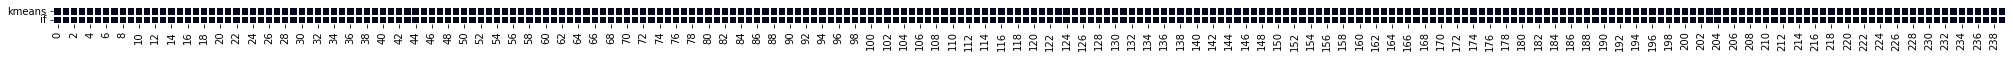

In [ ]:

f, ax = plt.subplots(figsize=(35, 35))
X = np.r_[[kmeans_result[0:240]],[isolationforest_result[0:240]]]
X = X.astype(int)
X.shape
ax = sns.heatmap(X, square=True, linewidths=1.0,
            yticklabels=['kmeans','if'], cbar=False,
            )

In [ ]:
def filter_anomaly(anomaly1,anomaly2):
  if anomaly1 & anomaly2:
    return 1
  else:
    return 0


func = np.vectorize(filter_anomaly)
final_anomaly = func(kmeans_anomaly,isolationforest_anomaly)

In [ ]:
df_transformed['anomaly'] = final_anomaly
df_transformed.anomaly.value_counts()

0    2245277
1      58013
Name: anomaly, dtype: int64

In [ ]:
df_transformed.sample(2)

,temperature,date,time,epoch,moteid,humidity,light,voltage,timestamp,anomaly
102801,-0.886598,2004-02-29,04:18:23.856796,3281,47,45.572,0.46,2.65143,2004-02-29 04:18:23.856796,1
613271,0.287187,2004-03-05,17:37:38.70502,19279,44,37.5051,566.72,2.65143,2004-03-05 17:37:38.705020,0


### analysis on anomaly result

In [ ]:
df_filtered = df_transformed[df_transformed['anomaly']==1]

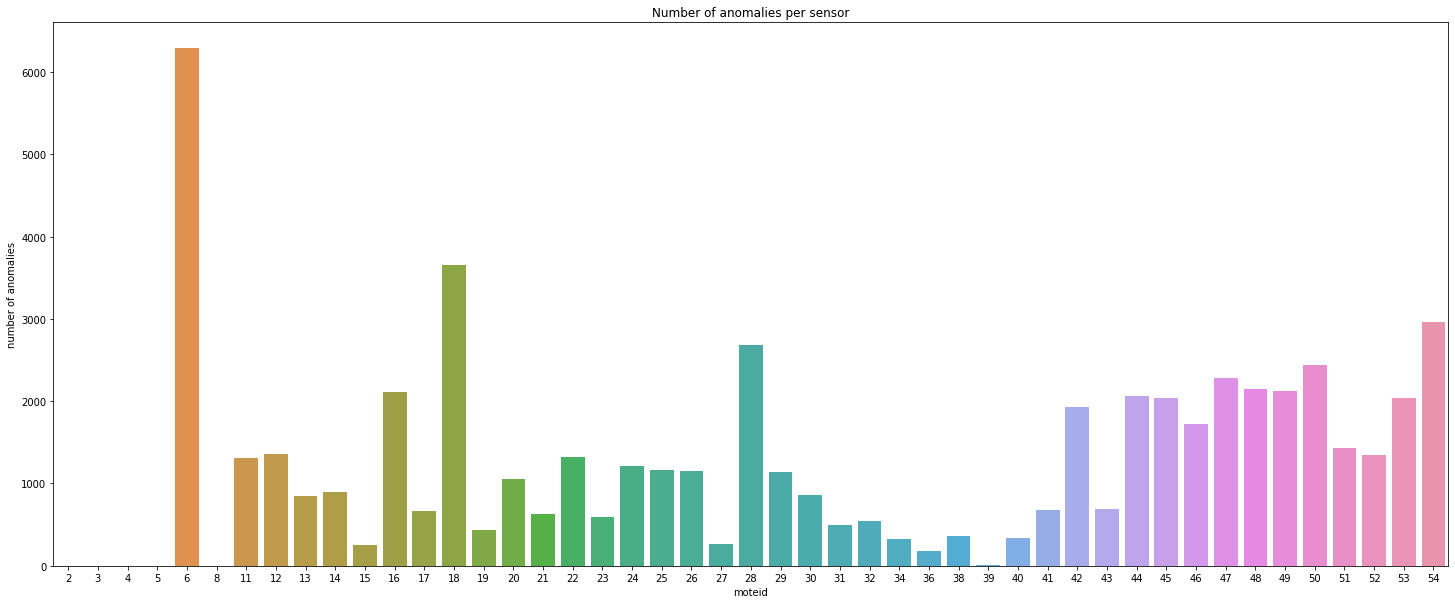

In [ ]:
plt.figure(figsize = (25,10))
sns.countplot(x = 'moteid',data = df_filtered)
plt.ylabel('number of anomalies')
plt.title("Number of anomalies per sensor")
plt.show();